In [1]:
versioninfo()

Julia Version 1.9.3
Commit bed2cd540a1 (2023-08-24 14:43 UTC)
Build Info:
  Official https://julialang.org/ release
Platform Info:
  OS: macOS (x86_64-apple-darwin22.4.0)
  CPU: 8 × Intel(R) Core(TM) i5-8279U CPU @ 2.40GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-14.0.6 (ORCJIT, skylake)
  Threads: 2 on 8 virtual cores


In [3]:
using Pkg
Pkg.activate(pwd())
Pkg.instantiate()
Pkg.status()

  Activating project at `~/Dropbox/class/M1399.000200/2023/M1300_000200-2023fall/lectures/17-qp`


Status `~/Dropbox/class/M1399.000200/2023/M1300_000200-2023fall/lectures/17-qp/Project.toml`
  [1e616198] COSMO v0.8.8
  [f65535da] Convex v0.15.4
  [a93c6f00] DataFrames v1.6.1
  [2e9cd046] Gurobi v1.2.0
  [b99e6be6] Hypatia v0.7.3
  [b6b21f68] Ipopt v1.5.1
  [b8f27783] MathOptInterface v1.22.0
  [6405355b] Mosek v10.1.3
  [1ec41992] MosekTools v0.15.1
  [91a5bcdd] Plots v1.39.0
  [c946c3f1] SCS v2.0.0


## Quadratic programming (QP)

![Source: Boyd and Vandeberghe](./qp.png){width=500}

---

* A (linearly constrained) **quadratic program** (QP) has quadratic objective function and affine constraint functions
$$
\begin{array}{ll}
	&\text{minimize}& (1/2) \mathbf{x}^T \mathbf{P} \mathbf{x} + \mathbf{q}^T \mathbf{x} + r \\
	&\text{subject to}& \mathbf{G} \mathbf{x} \leq \mathbf{h} \\
	& & \mathbf{A} \mathbf{x} = \mathbf{b},
\end{array}
$$
where we require $\mathbf{P} \in \mathbb{S}_+^d$ (why?). Apparently LP is a special case of QP with $\mathbf{P} = \mathbf{0}_{n \times n}$.

## Example 1: least squares

* The _least squares_ problem minimizes $\|\mathbf{y} - \beta_0\mathbf{1} - \mathbf{X} \beta\|_2^2$, which obviously is an (unconstrained) QP.
$$
    \min_{\beta} \frac{1}{2}\|\mathbf{y} - \beta_0\mathbf{1} - \mathbf{X} \beta\|_2^2 = \frac{1}{2}\beta^T\mathbf{X}^T\mathbf{X}\beta - (\mathbf{y - \beta_0\mathbf{1}})^T\mathbf{X}\beta + \frac{1}{2}\|\mathbf{y} - \beta_0\mathbf{1}\|_2^2.
$$
    + If the data is centered ($\mathbf{1}^T\mathbf{X} = \mathbf{0}$), then $\beta_0 = \frac{1}{n}\mathbf{y}$.

* Ridge regression.
$$
    \min_{\beta} \frac{1}{2}\|\mathbf{y} - \beta_0\mathbf{1} - \mathbf{X} \beta\|_2^2 + \frac{\lambda}{2}\|\beta\|_2^2
$$
    + $\mathbf{P} = \mathbf{X}^T\mathbf{X} + \lambda \mathbf{I} \in \mathbb{S}_{++}^d$
    + Usually the intercept $\beta_0$ is not penalized.
    + If the data is centered ($\mathbf{1}^T\mathbf{X} = \mathbf{0}$), then $\beta_0 = \frac{1}{n}\mathbf{y}$. (Why?)

---

[ Info: Precompiling IJuliaExt [2f4121a4-3b3a-5ce6-9c5e-1f2673ce168a]


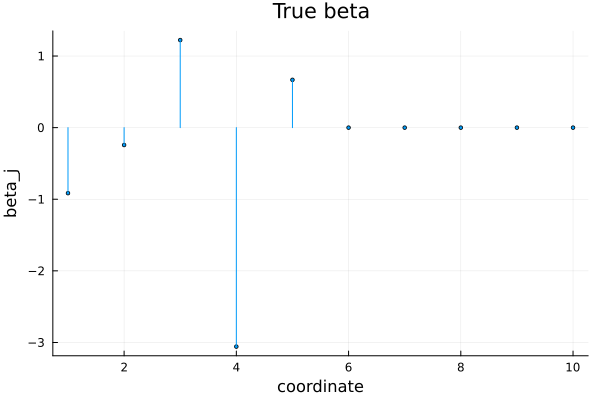

In [4]:
using Statistics
using Random, LinearAlgebra, SparseArrays

Random.seed!(123) # seed

n, p = 100, 10
# Design matrix
X0 = randn(n, p)
X = [ones(n, 1) (X0 .- mean(X0 ,dims=1)) ./ std(X0, dims=1)]   # design matrix is standardized and includes intercept
# True regression coefficients (first 5 are non-zero)
β = [1.0; randn(5); zeros(p - 5)]
# Responses
y = X * β + randn(n)

# plot the true β
using Plots

plt = plot(1:p, β[2:end], line=:stem, marker=2, legend=:none)
xlabel!(plt, "coordinate")
ylabel!(plt, "beta_j")
title!(plt, "True beta")

---

  1.251917 seconds (807.74 k allocations: 66.132 MiB, 1.98% gc time, 71.62% compilation time)


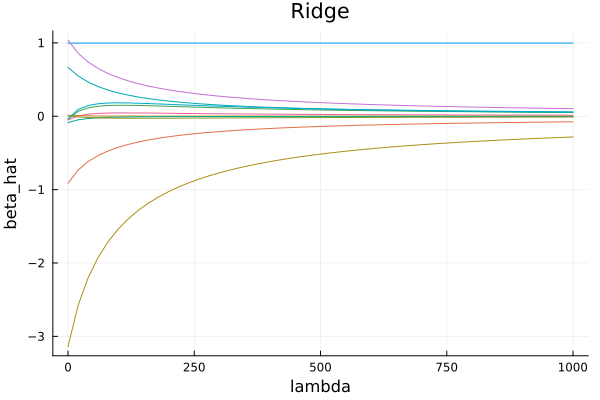

In [6]:
using Convex, MathOptInterface
using Mosek, MosekTools

const MOI = MathOptInterface

# solve at a grid of λ
λgrid = 0:20:1000
ridgepath = zeros(length(λgrid), size(X, 2)) # each row is β̂ at a λ
β̂ridge = Variable(size(X, 2))
@time for i in 1:length(λgrid)
    λ = λgrid[i]
    # objective
    problem = minimize(sumsquares(y - X * β̂ridge) + λ * sumsquares(β̂ridge[2:end]))
    solver = Mosek.Optimizer()   # MOSEK this time!
    MOI.set(solver, MOI.RawOptimizerAttribute("LOG"), 0)  # keep silent        
    solve!(problem, solver)
    ridgepath[i, :] = β̂ridge.value
end

plt = plot(collect(λgrid), ridgepath, legend=:none)
xlabel!(plt, "lambda")
ylabel!(plt, "beta_hat")
title!(plt, "Ridge")

## Example 2: constrained least squares

* Least squares with linear constraints. For example, _nonnegative least squares_ (NLS)
$$
\begin{array}{ll}
	&\text{minimize}& \frac 12 \|\mathbf{y} - \beta_0\mathbf{1} - \mathbf{X} \beta\|_2^2 \\
	&\text{subject to}& \beta \geq \mathbf{0}.
\end{array}    
$$

In [12]:
# Use COSMO solver
using COSMO
solver = COSMO.Optimizer()
## Use SCS solver
# using SCS
# solver = SCS.Optimizer()
## Use Mosek solver
# using Mosek, MosekTools
# solver = Mosek.Optimizer()
## Use Hypatia solver
# using Hypatia
# solver = Hypatia.Optimizer()


# Set up optimizaiton problem
β̂nonneg = Variable(size(X, 2))
problem = minimize(0.5sumsquares(y - X * β̂nonneg)) 
problem.constraints += β̂nonneg[2:end] >= 0

# Solve the problem
@time solve!(problem, solver)

------------------------------------------------------------------
          COSMO v0.8.8 - A Quadratic Objective Conic Solver
                         Michael Garstka
                University of Oxford, 2017 - 2022
------------------------------------------------------------------

Problem:  x ∈ R^{14},
          constraints: A ∈ R^{116x14} (1116 nnz),
          matrix size to factor: 130x130,
          Floating-point precision: Float64
Sets:     SecondOrderCone of dim: 101
          Nonnegatives of dim: 11
          SecondOrderCone of dim: 3
          ZeroSet of dim: 1
Settings: ϵ_abs = 1.0e-05, ϵ_rel = 1.0e-05,
          ϵ_prim_inf = 1.0e-04, ϵ_dual_inf = 1.0e-04,
          ρ = 0.1, σ = 1e-06, α = 1.6,
          max_iter = 5000,
          scaling iter = 10 (on),
          check termination every 25 iter,
          check infeasibility every 40 iter,
          KKT system solver: QDLDL
Acc:      Anderson Type2{QRDecomp},
          Memory size = 15, RestartedMemory,	
          Safegua

---

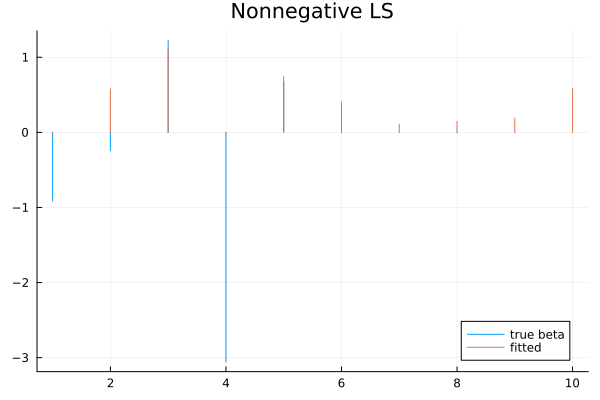

In [13]:
plot(β[2:end], line=:stem, label="true beta")
plot!(β̂nonneg.value[2:end], line=:stem, title="Nonnegative LS", label="fitted")

## Example 3: lasso

* Lasso regression [Tibshirani (1996)](https://www.jstor.org/stable/2346178), [Donoho (1994)](https://doi.org/10.1093/biomet/81.3.425) minimizes the least squares loss with $\ell_1$ (lasso) penalty
$$
\begin{array}{ll}
    \text{minimize}& \frac 12 \|\mathbf{y} - \beta_0 \mathbf{1} - \mathbf{X} \beta\|_2^2 + \lambda \|\beta\|_1,
\end{array}
$$
where $\lambda \ge 0$ is a tuning parameter. Writing $\beta = \beta^+ - \beta^-$, the equivalent QP is
$$
\small
\begin{array}{ll}
    \text{minimize}& \frac 12 (\beta^+ - \beta^-)^T \mathbf{X}^T \left(\mathbf{I} - \frac{\mathbf{1} \mathbf{1}^T}{n} \right) \mathbf{X} (\beta^+ - \beta^-) +  \mathbf{y}^T \left(\mathbf{I} - \frac{\mathbf{1} \mathbf{1}^T}{n} \right) \mathbf{X} (\beta^+ - \beta^-) + \lambda \mathbf{1}^T (\beta^+ + \beta^-) \\
    \text{subject to}& \beta^+ \geq \mathbf{0}, \, \beta^- \geq \mathbf{0}
\end{array}
$$
in $\beta^+$ and $\beta^-$; $\mathbf{x} = (\beta^+, \beta^-)$.

---

 17.769835 seconds (21.27 M allocations: 1.975 GiB, 4.78% gc time, 97.45% compilation time)


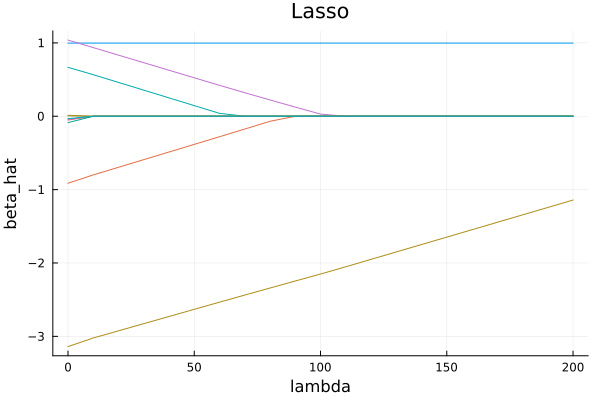

In [5]:
using Mosek, MosekTools

# solve at a grid of λ
λgrid = 0:10:200
β̂path = zeros(length(λgrid), size(X, 2)) # each row is β̂ at a λ
β̂lasso = Variable(size(X, 2))
@time for i in 1:length(λgrid)
    λ = λgrid[i]
    # objective
    problem = minimize(0.5sumsquares(y - X * β̂lasso) + λ * norm(β̂lasso[2:end], 1))
    solver = Mosek.Optimizer()   # MOSEK this time!
    MOI.set(solver, MOI.RawOptimizerAttribute("LOG"), 0)  # keep silent        
    solve!(problem, solver)
    β̂path[i, :] = β̂lasso.value
end

plt = plot(collect(λgrid), β̂path, legend=:none)
xlabel!(plt, "lambda")
ylabel!(plt, "beta_hat")
title!(plt, "Lasso")

## Example 4: elastic net

* Elastic net [Zou and Hastie (2005)](https://www.jstor.org/stable/3647580)
$$
\begin{array}{ll}
	&\text{minimize}& \frac 12 \|\mathbf{y} - \beta_0 \mathbf{1}  - \mathbf{X} \beta\|_2^2 + \lambda (\alpha \|\beta\|_1 + (1-\alpha) \|\beta\|_2^2),
\end{array}
$$
where $\lambda \ge 0$ and $\alpha \in [0,1]$ are tuning parameters.

---

  0.366815 seconds (491.97 k allocations: 42.703 MiB, 31.14% compilation time)


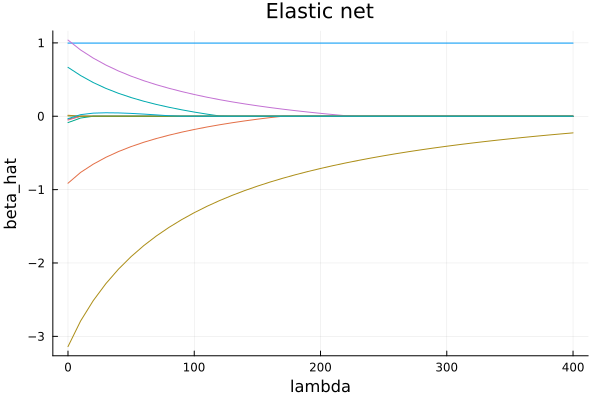

In [7]:
# solve at a grid of λ
λgrid = 0:10:400
alpha = 0.5
elastipath = zeros(length(λgrid), size(X, 2)) # each row is β̂ at a λ
β̂elastic = Variable(size(X, 2))
@time for i in 1:length(λgrid)
    λ = λgrid[i]
    # objective
    problem = minimize(0.5*sumsquares(y - X * β̂elastic) + 
        λ * (alpha*norm(β̂elastic[2:end],1) + (1-alpha)*sumsquares(β̂elastic[2:end])))
    solver = Mosek.Optimizer()   # MOSEK this time!
    MOI.set(solver, MOI.RawOptimizerAttribute("LOG"), 0)  # keep silent        
    solve!(problem, solver)
    elastipath[i, :] = β̂elastic.value
end

plt = plot(collect(λgrid), elastipath, legend=:none)
xlabel!(plt, "lambda")
ylabel!(plt, "beta_hat")
title!(plt, "Elastic net")

## QP example 5: constrained lasso

* (Linearly) constrained lasso
\begin{eqnarray*}
	&\text{minimize}& \frac 12 \|\mathbf{y} - \beta_0 \mathbf{1} - \mathbf{X} \beta\|_2^2 + \lambda \|\beta\|_1 \\
	&\text{subject to}& \mathbf{G} \beta \leq \mathbf{h} \\
	& & \mathbf{A} \beta = \mathbf{b},
\end{eqnarray*}
where $\lambda \ge 0$ is a tuning parameter. 

* We have seen this example (zero-sum lasso) before.

  0.115292 seconds (120.25 k allocations: 11.904 MiB)


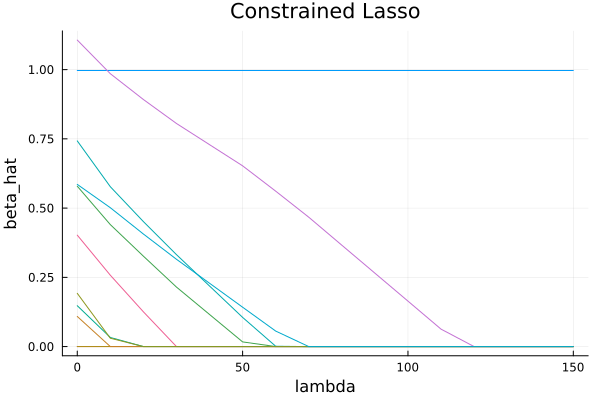

In [15]:
using Mosek, MosekTools

# solve at a grid of λ
λgrid = 0:10:150
β̂conpath = zeros(length(λgrid), size(X, 2)) # each row is β̂ at a λ
β̂conlasso = Variable(size(X, 2))
@time for i in 1:length(λgrid)
    λ = λgrid[i]
    # objective
    problem = minimize(0.5sumsquares(y - X * β̂conlasso) + λ * norm(β̂conlasso[2:end], 1))
    problem.constraints += β̂conlasso[2:end] >= 0
    solver = Mosek.Optimizer()   # MOSEK this time!
    MOI.set(solver, MOI.RawOptimizerAttribute("LOG"), 0)  # keep silent        
    solve!(problem, solver)
    β̂conpath[i, :] = β̂conlasso.value
end

plt = plot(collect(λgrid), β̂conpath, legend=:none)
xlabel!(plt, "lambda")
ylabel!(plt, "beta_hat")
title!(plt, "Constrained Lasso")

## QP example 7: robust regression

* The Huber loss function 
\begin{eqnarray*}
	\phi(r) = \begin{cases}
	r^2 & |r| \le M \\
	M(2|r| - M) & |r| > M
	\end{cases}
\end{eqnarray*}
is commonly used in robust statistics. The robust regression problem
\begin{eqnarray*}
	&\text{minimize}& \sum_{i=1}^n \phi(y_i - \beta_0 - \mathbf{x}_i^T \beta)
\end{eqnarray*}
can be transformed to a QP
\begin{eqnarray*}
	&\text{minimize}& \mathbf{u}^T \mathbf{u} + 2 M \mathbf{1}^T \mathbf{v} \\
	&\text{subject to}& - \mathbf{u} - \mathbf{v} \leq \mathbf{y} - \mathbf{X} \beta \leq \mathbf{u} + \mathbf{v} \\
	& & \mathbf{0} \leq \mathbf{u} \leq M \mathbf{1}, \mathbf{v} \geq \mathbf{0}
\end{eqnarray*}
in $\mathbf{u}, \mathbf{v} \in \mathbb{R}^n$ and $\beta \in \mathbb{R}^p$. Hint: write $|r_i| = (|r_i| \wedge M) + (|r_i| - M)_+ = u_i + v_i$.

<img src="./Huber-loss.png" width="500"/>

## QP example 8: SVM

* In two-class classification problems, we are given training data $(\mathbf{x}_i, y_i)$, $i=1,\ldots,n$, where $\mathbf{x}_i \in \mathbb{R}^n$ are feature vector and $y_i \in \{-1, 1\}$ are class labels. Support vector machine (SVM) solves the optimization problem
$$
\begin{array}{ll}
	&\text{minimize}& \sum_{i=1}^n \left[ 1 - y_i \left( \beta_0 + \sum_{j=1}^p x_{ij} \beta_j \right) \right]_+ + \lambda \|\beta\|_2^2,
\end{array}
$$
where $\lambda \ge 0$ is a tuning parameters. This is a QP (why?).

---

  1.881291 seconds (2.51 M allocations: 167.199 MiB, 4.83% gc time, 93.43% compilation time)


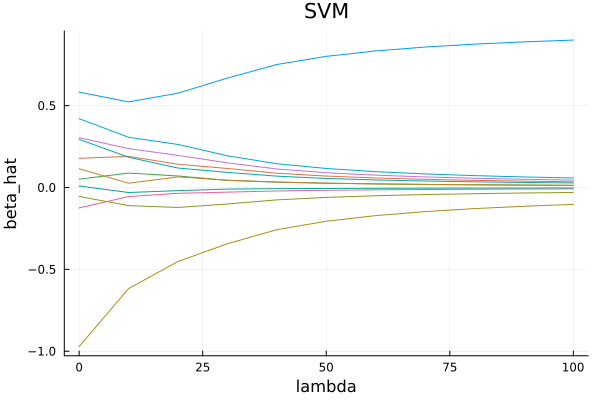

In [8]:
# convert to classification problem
Y = sign.(X * β + 5 * randn(n))

# solve at a grid of λ
λgrid = 0:10:100
β̂svmpath = zeros(length(λgrid), size(X, 2)) # each row is β̂ at a λ
β̂svm = Variable(size(X, 2))
@time for i in 1:length(λgrid)
    λ = λgrid[i]
    # objective
    problem = minimize(sum(pos(1 - Y .* (X * β̂svm))) + λ * sumsquares(β̂svm[2:end]))
    solver = Mosek.Optimizer()   # MOSEK this time!
    MOI.set(solver, MOI.RawOptimizerAttribute("LOG"), 0)  # keep silent        
    solve!(problem, solver)
    β̂svmpath[i, :] = β̂svm.value
end

plt = plot(collect(λgrid), β̂svmpath, legend=:none)
xlabel!(plt, "lambda")
ylabel!(plt, "beta_hat")
title!(plt, "SVM")
    